# Visualizing Neural network approximations to functions

### Imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LeakyReLU

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import altair as alt

In [2]:
from google.colab import drive
drive.mount('/content/drive')
images_dir = '/content/drive/My Drive/Images'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Auxiliary functions

In [3]:
# Plots ReLU components of the last layer of a fully connected NN
def ReLU_components_plotter(model,x,scaler_x=None,scaler_y=None,ymin=0):  
  L = len(model.layers)
  H = model.layers[-1].weights[0].shape[0]
  if scaler_x:
    X = scaler_x.transform(x)
  else:
    X = x
  Y = np.empty([H, len(X)])
  for l in range(L):
    W = model.layers[l].weights[0].numpy()
    B = model.layers[l].bias.numpy()
    if l < L-1:
      B = B[None,:]
      #print(X.shape)
      #print(W.shape)
      #print(b.shape)
      #print('*---*')
      X = tf.nn.relu(X@W + B)
    else: # Final layer
      #print(X.shape)
      #print(W.shape)
      #print(b.shape)
      #print('*---*')
      for f in range(H): #ReLU components
        y = X[:,f]*W[f]
        y = y.numpy().reshape(-1,1)
        if scaler_y:
          y = scaler_y.inverse_transform(y)
        Y[f] = y.squeeze()-ymin
      Z = X@W+B
      if scaler_y:
        B = scale_y.inverse_transform(B.reshape(-1,1))
        Z = scale_y.inverse_transform(Z)
      return Y,B,Z

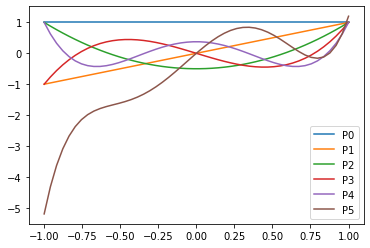

In [4]:
def Legendre_polynomials(n):
    a = 1
    b = 0
    c = 0
    if n==0:
            return lambda x: np.ones(len(x)) + c
    elif n==1:
            return lambda x: x + c
    elif n==2:
            return lambda x: (1/2)*(3*(x-b)**2-1) + c
    elif n==3:
            return lambda x: (1/2)*(5*(x-b)**3-3*x) + c
    elif n==4:
            return lambda x: (1/8)*(35*(a*x-b)**4-30*(a*x-b)**2+3) + c
    elif n==5:
            return lambda x: 1.2*(1/8)*(63*x**5-70*x**3+15*x) + 2*x - 2*x**2
    elif n==6:
            return lambda x: (1/16)*(231*x**6-315*x**4+105*x**2-5) + c
    elif n==7:
            return lambda x: (1/16)*(429*x**7-693*x**5+315*x**3-35*x) + c
    elif n==8:
            return lambda x: (1/128)*(6435*x**8-12012*x**6+6930*x**4-1260*x**2+35) + c
    elif n==9:
            return lambda x: (1/128)*(12155*x**9-25740*x**7+18018*x**5-4620*x**3+315*x) + c
    elif n==10:
            return lambda x: (1/256)*(46189*x**10-109395*x**8+90090*x**6-30030*x**4+3465*x**2-63) + c
    else:
        raise ValueError(f'n must be leq than 10')

def GaussianNoise(mu=0,sigma=0.5):
    return lambda x: np.random.normal(mu, sigma,len(x))
            
def function(base,noise):
    return lambda x: base(x) + noise(x)
    
N = 5

x_poli = np.linspace(-1,1,num=50)
for n in range(N+1):
    Poli = Legendre_polynomials(n)
    y_poli = Poli(x_poli)
    plt.plot(x_poli,y_poli,label = f'P{n}')
plt.legend();

### Preliminaries

### Ploting the original function

In [5]:
np.random.seed(0) # Set seed for numpy

mu = 0.
sigma = 0.15

func = function(Legendre_polynomials(N),GaussianNoise(mu,sigma))
y_noise = func(x_poli)

#plt.plot(x,Legendre_polynomials(N)(x),label = f'P{N}',color='black')
#plt.plot(x,y_noise, label = f'P{N} with noise', color='blue')
#plt.legend();

df = pd.DataFrame({'x': np.concatenate((x_poli,x_poli)), 'y': np.concatenate((y_poli,y_noise)), 'Function': ['Original']*len(x_poli)+['Noisy']*len(x_poli)})
alt.Chart(df).mark_line().encode(
    x='x',
    y='y',
    color=alt.Color('Function',
                   scale=alt.Scale(
            domain=['Original', 'Noisy'],
            range=['black', 'orange']))).mark_line(size=2)

alt.Chart(...)


### Sampling training and test data

In [6]:
np.random.seed(2)

n_data_points = 200

# Generate training points
x = np.linspace(-1, 1, num=n_data_points)
y = func(x)

# Split training and test set
mask = (np.arange(len(x)) % 5) >0 # 20% test set
x_train = x[mask]
x_test = x[~mask]
y_train = y[mask] 
y_test = y[~mask]

# Sort values for plotting
sort_train = np.argsort(x_train)
x_train = x_train[sort_train]
y_train = y_train[sort_train]

sort_test = np.argsort(x_test)
x_test = x_test[sort_test]
y_test = y_test[sort_test]

Test_MSE = dict()

poly_features = PolynomialFeatures(degree=10)

# Extend data with colums with the new features
x_train_poly = poly_features.fit_transform(x_train.reshape(-1,1))
x_test_poly = poly_features.fit_transform(x_test.reshape(-1,1))

In [7]:
d = {'x': np.concatenate((x_train,x_test)), 'y': np.concatenate((y_train,y_test)), 'Data': ['Train']*len(x_train)+['Test']*len(x_test)}
df = pd.DataFrame(data=d)
line = alt.Chart(pd.DataFrame({'x':x_poli,'y': y_poli,'Data': len(x_poli)*['Original']})).mark_line().encode(
      x='x',y='y',color=alt.value("#002474"))
scatter = alt.Chart(df).mark_circle(size=20).encode(
      x='x',
      y='y',
      color='Data',
      tooltip=['x','y']
      ).interactive()

line + scatter

alt.LayerChart(...)

## Solving the problem with linear regression on polynomial features

prediction =  -0.664x^0
Loss: 1.891
Test Mean Square Error: 2.186 

prediction =  -0.674x^0 + 2.03x^1
Loss: 0.5093
Test Mean Square Error: 0.6028 

prediction =  -0.0155x^0 + 2.05x^1 + -1.96x^2
Loss: 0.1624
Test Mean Square Error: 0.168 

prediction =  -0.0153x^0 + 2x^1 + -1.96x^2 + 0.0764x^3
Loss: 0.1622
Test Mean Square Error: 0.1668 

prediction =  -0.00877x^0 + 2x^1 + -2.02x^2 + 0.0749x^3 + 0.0749x^4
Loss: 0.1622
Test Mean Square Error: 0.1676 

prediction =  -0.0203x^0 + 4.28x^1 + -1.86x^2 + -10.5x^3 + -0.162x^4 + 9.44x^5
Loss: 0.02659
Test Mean Square Error: 0.02293 

prediction =  -0.0176x^0 + 4.29x^1 + -1.92x^2 + -10.5x^3 + 0.00488x^4 + 9.45x^5 + -0.122x^6
Loss: 0.02658
Test Mean Square Error: 0.02289 



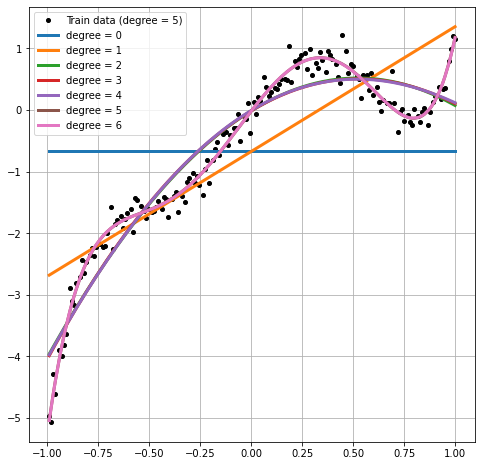

In [8]:
plt.figure(figsize=(8,8))

plt.plot(x_train,y_train,label=f'Train data (degree = {N})',color='black', 
         marker='o', linestyle='dashed',linewidth=0,markersize=4)

for d in range(N+2):
    linear_model = LinearRegression(fit_intercept=False)
    linear_model = linear_model.fit(x_train_poly[:,:d+1].reshape(-1,d+1), y_train)
    
    result = 'prediction = '
    for n,c in enumerate(linear_model.coef_):
        result = result + f' {linear_model.coef_[n]:.3g}x^{n} +'
    print(result[:-2].format(linear_model.coef_))

    y_pred_train = linear_model.predict(x_train_poly[:,:d+1].reshape(-1,d+1))
    loss = mean_squared_error(y_train,y_pred_train)
    print(f'Loss: {loss:.4g}')

    y_pred_test = linear_model.predict(x_test_poly[:,:d+1].reshape(-1,d+1))
    test_MSE = mean_squared_error(y_test,y_pred_test)

    Test_MSE['Linear ' + str(d)] = test_MSE
    print(f'Test Mean Square Error: {test_MSE:.4g} \n')

    y_pred = linear_model.predict(x_train_poly[:,:d+1].reshape(-1,d+1))
    plt.plot(x_train,y_pred,label=f'degree = {d}', linewidth=3)
plt.grid(True)
plt.legend()
plt.savefig(f"{images_dir}/Polynomial_approximations.png")
plt.show()

There is no overfitting with order 6 due to the high number of data points

## Solving the problem with a Neural Network

### Common parameters for all models

In [9]:
ini = 'he_uniform'

ini1 = tf.random_uniform_initializer(minval=-0.1, maxval=0.1)
ini_bias1 = tf.random_uniform_initializer(minval=-0.1, maxval=0.1)

ini2 = tf.random_normal_initializer(mean=0.3, stddev=0.05)
ini_bias2 = tf.random_uniform_initializer(minval=0.5, maxval=1)

loss = 'mse'

# optimizer = tf.keras.optimizers.SGD(lr=1e-1)
# optimizer = tf.keras.optimizers.RMSprop(lr=1e-4)
optimizer = tf.keras.optimizers.Adam(lr=1e-3)

cb_earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='mse', min_delta=0.0005, patience=50, verbose=True, mode='auto',
    baseline=None, restore_best_weights=True
)
verbose = 0
epochs = 500

### Model with a single node: Recover (unique) linear solution

In [10]:
model0 = tf.keras.Sequential([
         tf.keras.layers.Dense(1, activation='linear', name='fc1', input_dim=1)
            ])
model0.summary()

model0.compile(optimizer=optimizer,
                   loss=loss,
                   metrics=['mse'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc1 (Dense)                  (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


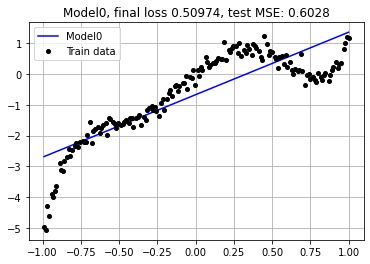

In [11]:
history0 = model0.fit(x_train.reshape(-1,1), y_train.reshape(-1,1),
                      epochs=epochs,
                      batch_size=round(x_train.shape[0]/50),
                      verbose=verbose)
    
y_pred = model0.predict(x_train.reshape(-1,1))
    
plt.plot(x_train,y_pred,label = 'Model0', c='blue')
plt.plot(x_train,y_train,label = 'Train data',color='black', 
         marker='o', linestyle='dashed',linewidth=0,markersize=4)
#plt.plot(x_test, y_test, '.', markersize=4, color='blue', label = 'Test data')


final_loss = history0.history['loss'][-1]
y_test_pred = model0.predict(x_test)
test_MSE = mean_squared_error(y_test,y_test_pred)
plt.title(f'Model0, final loss {final_loss:.5g}, test MSE: {test_MSE:.5g}')
plt.grid(True)
plt.legend()
plt.savefig(f"{images_dir}/Model0.png")

In [12]:
Test_MSE['Model0'] = test_MSE

In [13]:
# parameters of the resulting fit
a = model0.get_weights()[0][0,0]
b = model0.get_weights()[1][0]

In [14]:
print(f'prediction = {b:.3g} + {a:.3g}x')
print(f'Test Mean Square Error: {test_MSE:.4g}')

prediction = -0.677 + 2.03x
Test Mean Square Error: 0.6028


#### Plotting the loss surface

In [15]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm

def f(m,b):
    yhat = x_train*m+b
    return np.mean((y_train - yhat) ** 2)

mmin,mmax,bmin,bmax = 1.25,3,-1.2,0

nm = 300
nb = 300
u = np.linspace(mmin, mmax, nm) 
v = np.linspace(bmin, bmax, nb)

xx = np.zeros((nm,nb),dtype='d')
yy = np.zeros((nm,nb),dtype='d')
zz = np.zeros((nm,nb),dtype='d')

# populate x,y,z arrays
for i in range(nm):
    for j in range(nb):
        xx[i,j] = u[i]
        yy[i,j] = v[j]
        zz[i,j] = min(f(xx[i,j],yy[i,j]),3)

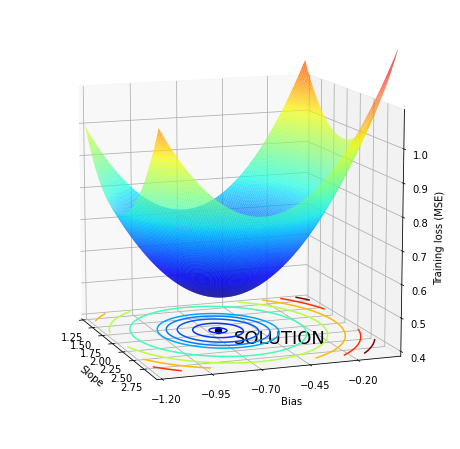

<Figure size 432x288 with 0 Axes>

In [16]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca(projection='3d')

# Plot the 3D surface
ax.plot_surface(xx, yy, zz, rstride=2, cstride=2, alpha=0.8,cmap=cm.jet)

# Plot projections of the contours for each dimension.  By choosing offsets
# that match the appropriate axes limits, the projected contours will sit on
# the 'walls' of the graph
cset = ax.contour(xx, yy, zz, zdir='MSE', offset=0.4, cmap=cm.jet, levels=[0.4,0.45,0.475,0.5,0.51125,0.525,0.55,0.575,0.6,0.7,0.8,0.9,1.0,1.1])

ax.set_xlim(mmin, mmax)
ax.xaxis.set_ticks(np.arange(mmin, mmax, 0.25))

ax.set_ylim(bmin, bmax)
ax.yaxis.set_ticks(np.arange(bmin, bmax, 0.25))

ax.set_zlim(0.5, 1.1)
ax.zaxis.set_ticks(np.arange(0.4, 1.1, 0.1))

ax.set_xlabel('Slope')
ax.set_ylabel('Bias')
ax.set_zlabel('Training loss (MSE)')

ax.view_init(elev=12., azim=-20)

# Obtained solution
ax.scatter(a, b, zs=0.40, zdir='z', c='k', s=40, marker = 'o')
ax.text(1.2*a, 1.02*b, 0.40, s='SOLUTION', fontsize=18)
plt.show()
plt.savefig(f"{images_dir}/LossSurface.png")

### Model with one hidden layer with a single node

loss =  0.5094889998435974, seed = 61856360


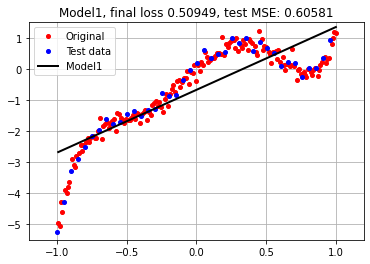

In [27]:
while True:
  nn = 1
  seed = np.random.randint(0,1e8)
  tf.random.set_seed(seed)

  optimizer1 = tf.keras.optimizers.Adam(lr=1e-3)

  model1 = tf.keras.Sequential([
      tf.keras.layers.Dense(nn, activation='relu', name='fc1', input_dim=1, 
                            kernel_initializer = ini2),
      tf.keras.layers.Dense(1)
                      ])

  model1.compile(optimizer=optimizer,
              loss=loss,
              metrics=['mse'])

  history1 = model1.fit(x_train.reshape(-1,1), y_train.reshape(-1,1),
                epochs=epochs,
                callbacks=[],
                batch_size=round(x_train.shape[0]/20),
                verbose=verbose)

  y_pred = model1.predict(x_train.reshape(-1,1))
  final_loss = history1.history['loss'][-1]
  print(f'loss =  {final_loss}, seed = {seed}')

  if final_loss < 0.51:
      y_pred = model1.predict(x_train.reshape(-1,1))

      y_test_pred = model1.predict(x_test)
      test_MSE = mean_squared_error(y_test,y_test_pred)

      plt.title(f'Model1, final loss {final_loss:.5g}, test MSE: {test_MSE:.5g}')
      plt.plot(x_train,y_train,label = 'Original',color='red', 
              marker='o', linestyle='dashed', linewidth=0, markersize=4)
      plt.plot(x_test,y_test,label = 'Test data',color='b', 
              marker='o', linestyle='dashed', linewidth=0, markersize=4)

      plt.plot(x_train,y_pred,label = 'Model1', c ='k',linewidth=2)
      plt.legend()
      plt.grid()
      plt.axis((-1.2,1.2,-5.5,1.5))
      plt.savefig(f"{images_dir}/Model1.png")
      plt.show()
      break

The resulting fit is still a linear approximation. Even though the model is able to represent a single ReLU function, it chose not to use it since it would not result in a lower loss.

In [18]:
model1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc1 (Dense)                  (None, 1)                 2         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 2         
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


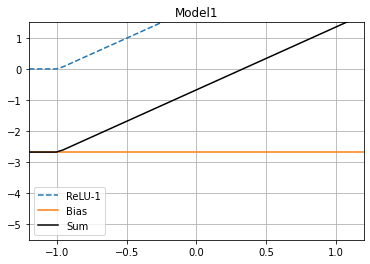

In [28]:
X = np.linspace(-1.2, 1.2, num=50).reshape(-1, 1)
Y,B,Z = ReLU_components_plotter(model1,X)
for i in range(Y.shape[0]):
  plt.plot(X,Y[i,:], '--' ,label='ReLU-'+str(i+1))
plt.plot(X,B*np.ones_like(X), label='Bias')    
plt.plot(X,np.transpose(np.sum(Y,axis=0)).reshape(-1,1)+B, label='Sum',color='k')
plt.grid()
plt.legend()
plt.title('Model1')
plt.axis((-1.2,1.2,-5.5,1.5))
plt.savefig(f"{images_dir}/Model1_decomp.png")
plt.show()

It can be seen how te value of the single ReLU has its singularity just outside of the range of values under consideration

In [20]:
Test_MSE['Model1'] = test_MSE
# Error is much lower 
# Remember that this is Mean square error, so that the values are
# comparable even though the points are different

### Model with one hidden layer with 2 nodes.

#### Separately scale the input and output variables

In [21]:
print(x_train.min(), x_train.max(), y_train.min(), y_train.max())

scale_x = MinMaxScaler()
x_train_scaled = scale_x.fit_transform(x_train.reshape(-1,1))
scale_y = MinMaxScaler()
y_train_scaled = scale_y.fit_transform(y_train.reshape(-1,1))

x_test_scaled = scale_x.transform(x_test.reshape(-1,1))  # Note: not fit_transform
y_test_scaled = scale_y.transform(y_test.reshape(-1,1))  # Note: not fit_transform

print(x_train_scaled.min(), x_train_scaled.max(), y_train_scaled.min(), y_train_scaled.max())

-0.9899497487437185 1.0 -5.063604817585751 1.2224737600314832
0.0 0.9999999999999999 0.0 1.0


#### Shuffling of the data scaling

We create a dataset object to feed it to the model. It is important to shuffle the data since it was created in a very strict order which could introduce
biases in the training of the model.
Also relevant is the fact that batch size should be less than the length whole dataset. Even though it is possible to run a full gradient on the whole dataset due to the small size of the problem, it is usually less efficient than stochastic gradient descent (it doesn't take advantage of data redundancy) and it can get stuck in worse local minima.

In [22]:
# Batch size is really important! Full GD fails to find a good minimum and SGD
# usually works faster and finds a better minimum
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_scaled, y_train_scaled))
train_dataset = train_dataset.shuffle(buffer_size=80).batch(20)

#    test_dataset = tf.data.Dataset.from_tensor_slices((x_test_scaled, y_test_scaled))
#    test_dataset = test_dataset.batch(20)

loss =  0.004019450396299362, seed = 14854524
loss =  0.012990569695830345, seed = 40718025
loss =  0.0025001252070069313, seed = 21042088
loss =  0.00379702216014266, seed = 50401775
loss =  0.013619202189147472, seed = 69220106
loss =  0.00465292576700449, seed = 18694340
loss =  0.004505453631281853, seed = 38628070
loss =  0.012839275412261486, seed = 1087757
loss =  0.003974694758653641, seed = 52979486
loss =  0.013761821202933788, seed = 71203282
loss =  0.003991449251770973, seed = 83299543
loss =  0.013677751645445824, seed = 21535962
loss =  0.012903966009616852, seed = 29549713
loss =  0.004299299791455269, seed = 3356031
loss =  0.007328377105295658, seed = 68608933
loss =  0.003812035545706749, seed = 21876294
loss =  0.0038143072742968798, seed = 49750585
loss =  0.0038273136597126722, seed = 65553022
loss =  0.003956544678658247, seed = 68441629
loss =  0.012989945709705353, seed = 83641007
loss =  0.004281527362763882, seed = 20621496
loss =  0.013235202059149742, seed 

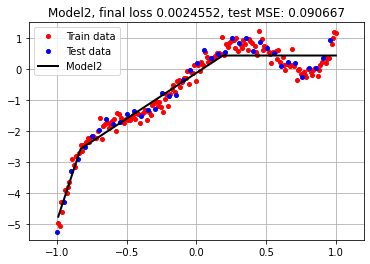

In [23]:
# This model includes previous model, so minimum should be lower. However, depends on training
while True: # Loop over different seeds
    nn = 2
    seed = np.random.randint(0,1e8)
    tf.random.set_seed(seed)    

    model2 = tf.keras.Sequential([
                tf.keras.layers.Dense(nn, activation='relu', name='fc1', input_dim=1, 
                                      kernel_initializer = ini,
                                      bias_initializer=ini_bias2),
                tf.keras.layers.Dense(1, activation='linear', name='fc2', 
                                      kernel_initializer = ini,
                                      bias_initializer=ini_bias2),
                ])

    model2.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-2),
                       loss=loss,
                       metrics=['mse'])

    history2 = model2.fit(train_dataset,
                          epochs=epochs,
                          callbacks=[],#[cb_earlystop],
                          verbose=verbose)

    # batch size is really important! Full GD fails to find better minimum
    final_loss = history2.history['loss'][-1]
    print(f'loss =  {final_loss}, seed = {seed}')
    
    if final_loss < 0.0025: # Stop when a good solution is found
        
        y_pred_scaled = model2.predict(x_train_scaled)
        y_test_scaled = model2.predict(x_test_scaled)

        # Reverse the scaling
        y_plot_pred = scale_y.inverse_transform(y_pred_scaled)
        y_test_pred = scale_y.inverse_transform(y_test_scaled)

        test_MSE = mean_squared_error(y_test,y_test_pred)

        plt.title(f'Model2, final loss {final_loss:.5g}, test MSE: {test_MSE:.5g}')
        plt.plot(x_train,y_train,label = 'Train data',color='red', 
                marker='o', linestyle='dashed', linewidth=0, markersize=4)
        plt.plot(x_test,y_test,label = 'Test data',color='b', 
                marker='o', linestyle='dashed', linewidth=0, markersize=4)

        plt.plot(x_train,y_plot_pred,label = 'Model2', c ='k', linewidth=2)
        plt.legend()
        plt.grid()
        plt.axis((-1.2,1.2,-5.5,1.5))
        plt.savefig(f"{images_dir}/Model2.png")
        plt.show()
        break

The neural net correctly places the two ReLU function that it can represent to better approximate the left side, which minimizes MSE. The right side is fit using a constant approximation,since there are no more ReLU components available to produce a better fit. It takes several tries to find this solution however, as the method seems to quickly converge to non-optimal minima.

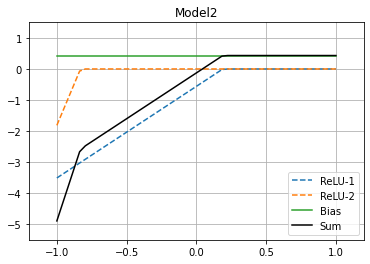

In [30]:
X = np.linspace(-1, 1, num=50).reshape(-1, 1)
Y,B,Z = ReLU_components_plotter(model2,X,scale_x,scale_y,y_train.min())
for i in range(Y.shape[0]):
  plt.plot(X,Y[i,:], '--' ,label='ReLU-'+str(i+1))
plt.plot(X,B*np.ones_like(X), label='Bias')    
plt.plot(X,np.transpose(np.sum(Y,axis=0)).reshape(-1,1)+B, label='Sum',color='k')
plt.grid()
plt.legend()
plt.title('Model2')
plt.axis((-1.2,1.2,-5.5,1.5))
plt.savefig(f"{images_dir}/Model2_decomp.png")
plt.show()

In [25]:
model2.summary()
model2.get_weights()

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc1 (Dense)                  (None, 2)                 4         
_________________________________________________________________
fc2 (Dense)                  (None, 1)                 3         
Total params: 7
Trainable params: 7
Non-trainable params: 0
_________________________________________________________________


[array([[-1.3116454, -2.3642976]], dtype=float32),
 array([0.77781314, 0.18967547], dtype=float32),
 array([[-0.7118153],
        [-1.4321989]], dtype=float32),
 array([0.8743253], dtype=float32)]

In [26]:
Test_MSE['Model2'] = test_MSE

### Model with one hidden layer with 3 nodes

In [ ]:
while True: # Loop over different seeds
    nn = 3
    seed = np.random.randint(0,1e8)
    tf.random.set_seed(seed)    

    model3 = tf.keras.Sequential([
                tf.keras.layers.Dense(nn, activation='relu', name='fc1', input_dim=1, 
                                      kernel_initializer = ini,
                                      bias_initializer=ini_bias2),
                tf.keras.layers.Dense(1, activation='linear', name='out', 
                                      kernel_initializer = ini,
                                      bias_initializer=ini_bias2),
                ])

    model3.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-3),
                       loss=loss,
                       metrics=['mse'])

    history3 = model3.fit(train_dataset,
                          epochs=4*epochs,
                          callbacks=[],
                          verbose=verbose)


    final_loss = history3.history['loss'][-1]
    print(f'loss =  {final_loss}, seed = {seed}')
    
    if final_loss < 0.002: # Stop when a good solution is found
        
        y_pred_scaled = model3.predict(x_train_scaled)
        y_test_scaled = model3.predict(x_test_scaled)

        # Reverse the scaling
        y_plot_pred = scale_y.inverse_transform(y_pred_scaled)
        y_test_pred = scale_y.inverse_transform(y_test_scaled)

        test_MSE = mean_squared_error(y_test,y_test_pred)

        plt.title(f'Model3, final loss {final_loss:.5g}, test MSE: {test_MSE:.5g}')
        plt.plot(x_train,y_train,label = 'Train data',color='red', 
                marker='o', linestyle='dashed', linewidth=0, markersize=4)
        plt.plot(x_test,y_test,label = 'Test data',color='b', 
                marker='o', linestyle='dashed', linewidth=0, markersize=4)

        plt.plot(x_train,y_plot_pred,label = 'Model3', c ='k', linewidth=2)
        plt.legend()
        plt.grid()
        plt.axis((-1.2,1.2,-5.5,1.5))
        plt.savefig(f"{images_dir}/Model3.png")
        plt.show()
        break

loss =  0.0037260197568684816, seed = 54535594
loss =  0.012918783351778984, seed = 19340524
loss =  0.012930427677929401, seed = 17688432
loss =  0.012917006388306618, seed = 32073965
loss =  0.0037226721178740263, seed = 6308819
loss =  0.012907964177429676, seed = 82515722
loss =  0.0037600479554384947, seed = 72191626
loss =  0.00375472498126328, seed = 16048659
loss =  0.012924963608384132, seed = 1809639


Many different initializations were needed to obtain a solution superior to the previous one.
Three ReLU components provide a pretty good structure for the approximating function to give good results.

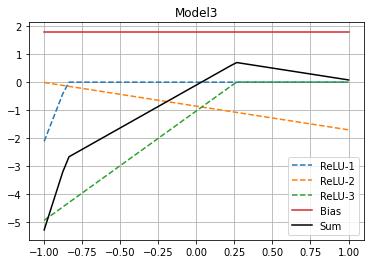

<Figure size 432x288 with 0 Axes>

In [28]:
X = np.linspace(-1, 1, num=50).reshape(-1, 1)
Y,B,Z = ReLU_components_plotter(model3,X,scale_x,scale_y,y_train.min())
#print(np.sum(Y,axis=0)+B-np.transpose(Z))
for i in range(Y.shape[0]):
  plt.plot(X,Y[i,:], '--' ,label='ReLU-'+str(i+1))
plt.plot(X,B*np.ones_like(X), label='Bias')    
plt.plot(X,np.transpose(np.sum(Y,axis=0)).reshape(-1,1)+B, label='Sum',color='k')
plt.grid()
plt.legend()
plt.title('Model3')
plt.axis((-1.2,1.2,-5.5,1.5))
plt.savefig(f"{images_dir}/Model3_decomp.png")
plt.show()

In [29]:
Test_MSE['Model3'] = test_MSE

### Models of increasing sizes

loss =  0.0020709321834146976, seed = 78023172
loss =  0.0008182682213373482, seed = 26640320
loss =  0.0009747703443281353, seed = 53216735
loss =  0.0009354554349556565, seed = 75751270
loss =  0.0010328285861760378, seed = 35555018
loss =  0.0009994411375373602, seed = 71822705
loss =  0.0008191786473616958, seed = 88267135
loss =  0.0009681048686616123, seed = 53241192


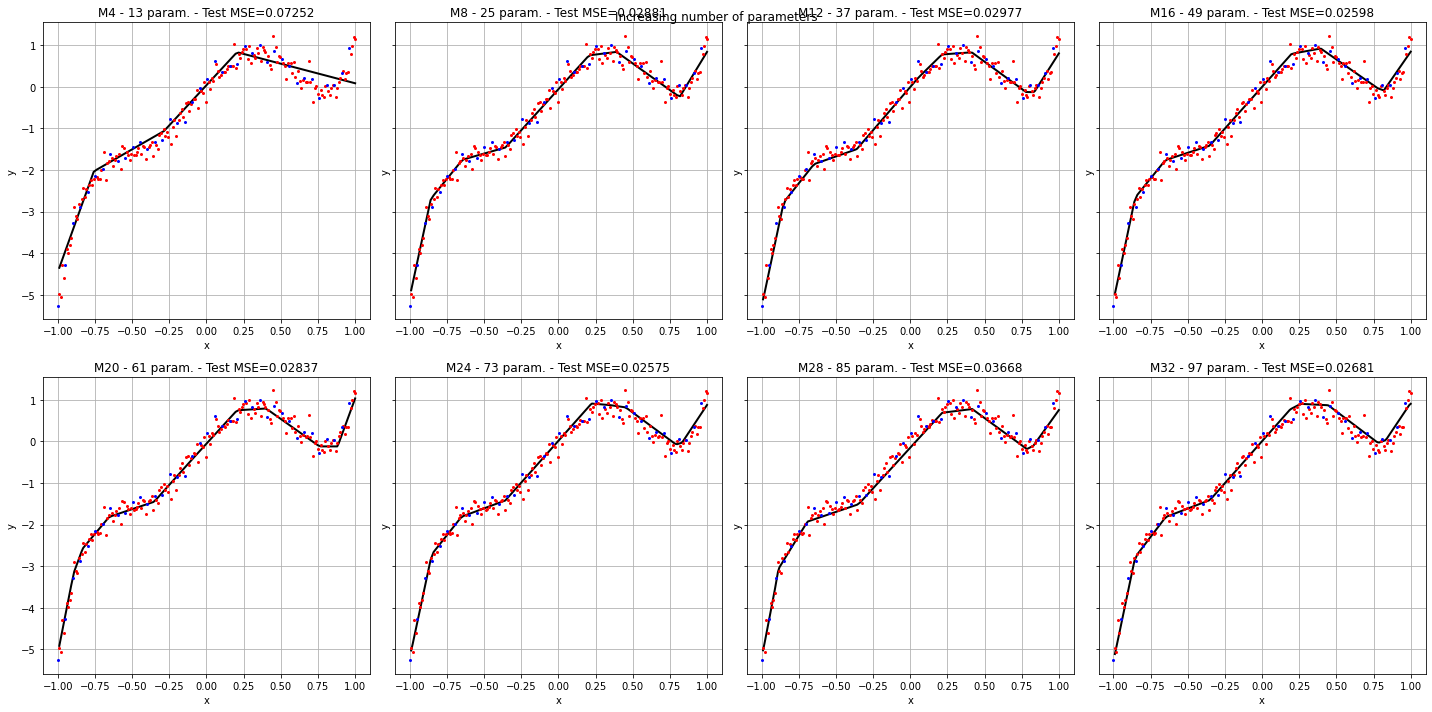

In [30]:
nmodels = 8

stats = dict()
stats['Nparam']=[]
stats['Loss']=[]
stats['Test_MSE']=[]
stats['Curves']=[]

ncols = 4
nrows = round(nmodels // ncols)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 10), sharey=True)
axes_list = [item for sublist in axes for item in sublist] 

fig.subplots_adjust(hspace=0.5)
fig.suptitle('Increasing number of parameters')

for nn in range(0,nmodels):
    seed = np.random.randint(0,1e8)
    tf.random.set_seed(seed)    

    n = 4*nn+ 4

    model = tf.keras.Sequential([
                tf.keras.layers.Dense(n, activation='relu', name='fc1', input_dim=1, 
                                      kernel_initializer = ini,
                                      bias_initializer=ini_bias2),
                tf.keras.layers.Dense(1, activation='linear', name='out', 
                                      kernel_initializer = ini,
                                      bias_initializer=ini_bias2),
                ])

    model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-2),
                       loss=loss,
                       metrics=['mse'])

    history = model.fit(train_dataset,
                        epochs=10*epochs,
                        callbacks=[],#[cb_earlystop],
                        verbose=verbose, 
                        shuffle=True)

    final_loss = history.history['loss'][-1]
    print(f'loss =  {final_loss}, seed = {seed}')
    
        
    y_pred_scaled = model.predict(x_train_scaled)
    y_test_scaled = model.predict(x_test_scaled)

    # Reverse the scaling
    y_plot_pred = scale_y.inverse_transform(y_pred_scaled)
    y_test_pred = scale_y.inverse_transform(y_test_scaled)

    test_MSE = mean_squared_error(y_test,y_test_pred)

    ax = axes_list[nn]
    ax.set_xlabel('x', size=10)
    ax.set_ylabel('y', size=10)
    
    stats['Nparam'].append(model.count_params())
    stats['Loss'].append(final_loss)
    stats['Test_MSE'].append(test_MSE)
    stats['Curves'].append(y_plot_pred)

    s = 'M'+ str(n) + ' - ' + str(model.count_params()) + ' param. - Test MSE=' + "{:.5f}".format(test_MSE)
    ax.set_title(s)
    ax.plot(x_train, y_plot_pred, c ='k', linewidth=2)

    ax.plot(x_train, y_train, label = 'Train data',color='red', 
                marker='o', linestyle='dashed', linewidth=0, markersize=2)
    
    ax.plot(x_test,y_test,label = 'Test data',color='b', 
                marker='o', linestyle='dashed', linewidth=0, markersize=2)
    ax.grid()
fig.tight_layout()
fig.savefig(f"{images_dir}/ModelN.png")

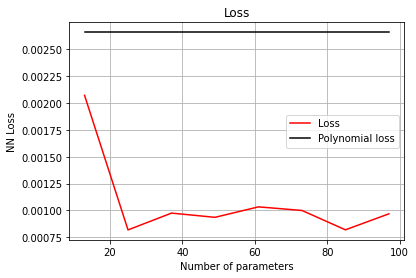

In [31]:
plt.plot(stats['Nparam'],stats['Loss'], label='Loss', color='red')
plt.plot(stats['Nparam'],0.002658*np.ones_like(stats['Nparam']),label='Polynomial loss', color='black')
plt.xlabel('Number of parameters')
plt.ylabel('NN Loss')
plt.legend()
plt.grid()
plt.title('Loss')
plt.savefig(f"{images_dir}/Loss.png")
plt.show()

The nets are starting to overfit the training points a little

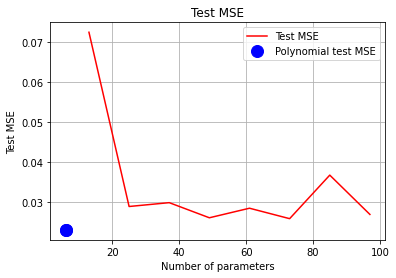

In [32]:
plt.plot(stats['Nparam'],stats['Test_MSE'], label='Test MSE', color='red')
plt.plot([6,6.1],[0.02293,0.023],'bo', linewidth=2, markersize=12,label='Polynomial test MSE')
plt.xlabel('Number of parameters')
plt.ylabel('Test MSE')
plt.legend()
plt.grid()
plt.title('Test MSE')
plt.savefig(f"{images_dir}/TestMSE.png")
plt.show()

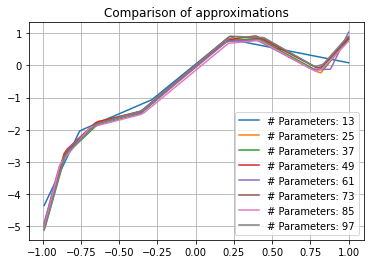

In [33]:
for i in range(len(stats['Curves'])):
  plt.plot(x_train,stats['Curves'][i], label='# Parameters: ' + str(stats['Nparam'][i]))
plt.grid()
plt.title('Comparison of approximations')
plt.legend()
plt.savefig(f"{images_dir}/Curves.png")
plt.show()

## Try other activations just for fun (Work in progress)